# Deterministic Pursuit-Only Dynamics

- The predator accelerates in a straight line towards the prey
- The predator has higher speed than the prey

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

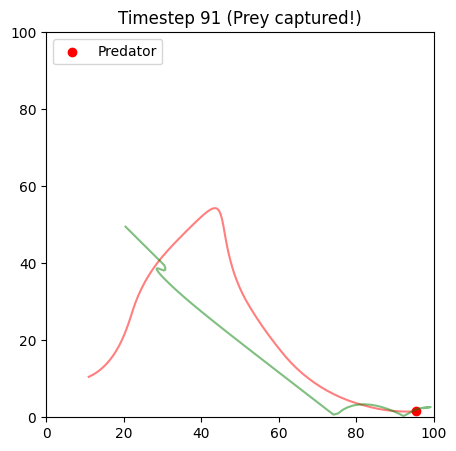

In [3]:
# --- 1) PARAMETERS ---------------------------------------------------
dt       = 1.0       # your timestep
n_steps  = 100       # number of frames
bounds   = (0, 100)  # plotting limits [min, max] on both axes
pred_maxspeed = 3
prey_maxspeed = 1.5
pred_maxacc = 0.1
prey_maxacc = 0.3
capture_thresh = 2.5
flee_thresh = 7.5

# --- 2) INITIALIZE STATE TENSOR --------------------------------------
# agents indexed 0=predator, 1=prey; features 0=pos,1=vel,2=acc; dims 2D
state = np.zeros((2, 3, 2), dtype=float)

# initial predator pos, vel, acc
state[0, 0] = [10, 10]  
state[0, 1] = [ 1,  0.5] 
state[0, 2] = [ 0, 0] 

# initial prey pos, vel, acc
state[1, 0] = [20, 50]
state[1, 1] = [0.5, -0.5]
state[1, 2] = [   0,  0] 

def step(state, dt):
    """
    state: (2 agents, 3 features, 2 dims)
    features are [pos, vel, acc]; we want
      pos += vel * dt
      vel += acc * dt
    """
    # adds dt * vel to both pos and vel-update (pos += vel*dt, vel += acc*dt)
    state[:, :2, :] += dt * state[:, 1:, :]
    return state

def handle_boundaries(state, bounds):
    """
    Check if agents hit boundaries and reverse their direction if so
    """
    min_bound, max_bound = bounds

    # For each agent
    for agent in range(2):

        # Check x-boundaries
        if state[agent, 0, 0] <= min_bound:
            state[agent, 0, 0] = min_bound + 1  # Move agent slightly inside boundary
            state[agent, 1, 0] *= -1  # Reverse x velocity
        elif state[agent, 0, 0] >= max_bound:
            state[agent, 0, 0] = max_bound - 1
            state[agent, 1, 0] *= -1
            
        # Check y-boundaries
        if state[agent, 0, 1] <= min_bound:
            state[agent, 0, 1] = min_bound + 1
            state[agent, 1, 1] *= -1  # Reverse y velocity
        elif state[agent, 0, 1] >= max_bound:
            state[agent, 0, 1] = max_bound - 1
            state[agent, 1, 1] *= -1
    
    return state

def normalize(v):
    length = np.linalg.norm(v)
    if length == 0:
        return np.zeros_like(v)
    return v / length

def chase(state, max_speed=2.0, max_force=0.1):
    direction = state[1, 0] - state[0, 0]
    velocity = normalize(direction) * max_speed
    steering = velocity - state[0, 1]
    
    # Clamp steering to max_force
    steering_norm = np.linalg.norm(steering)
    if steering_norm > max_force:
        steering = steering / steering_norm * max_force

    state[0, 2] = steering
    return state

def flee(state, max_speed=1.0, max_force=0.3):
    direction = np.random.randn(2)
    velocity = normalize(direction) * max_speed
    steering = velocity - state[1, 1]

    steering_norm = np.linalg.norm(steering)
    if steering_norm > max_force:
        steering = steering / steering_norm * max_force
    
    state[1, 2] = steering
    return state

def limit_vector(state, agent_idx, feature_idx, max_val):
    vector = np.linalg.norm(state[agent_idx, feature_idx])
    if vector > max_val:
        state[agent_idx, feature_idx] = (state[agent_idx, feature_idx] / vector) * max_val
    return state

pred_trail = []
prey_trail = []
prey_captured = False

# --- 3) RUN & PLOT LOOP ----------------------------------------------
for timestep in range(n_steps):
    # 1) vectorized update
    state = step(state, dt)

    # 2) limit speed
    state = limit_vector(state, agent_idx=0, feature_idx=1, max_val=pred_maxspeed)
    state = limit_vector(state, agent_idx=1, feature_idx=1, max_val=prey_maxspeed)

    # 3) handle boundary collisions
    state = handle_boundaries(state, bounds)

    # 4) collision or flee check
    distance = np.linalg.norm(state[0, 0] - state[1, 0])
    if distance < capture_thresh: #capture thresholad
        prey_captured = True
        state[0,1] = [0, 0]   # predator stops moving

    if prey_captured:
        # 7) draw before breaking
        pred_x, pred_y = state[0,0]
        pred_trail.append(state[0,0].copy())
        pred_trail_np = np.array(pred_trail)

        clear_output(wait=True)
        plt.figure(figsize=(5,5))
        plt.xlim(*bounds)
        plt.ylim(*bounds)
        plt.scatter(pred_x, pred_y, color='red', label='Predator')
        plt.plot(pred_trail_np[:,0], pred_trail_np[:,1], color='red', alpha=0.5)
        plt.plot(prey_trail_np[:,0], prey_trail_np[:,1], color='green', alpha=0.5)
        plt.legend(loc='upper left')
        plt.title(f"Timestep {timestep} (Prey captured!)")
        plt.show()
        
        break

    # 5) chase and flee
    if distance < flee_thresh:
        state = flee(state)
        state = limit_vector(state, agent_idx=1, feature_idx=2, max_val=prey_maxacc)

    state = chase(state)
    state = limit_vector(state, agent_idx=0, feature_idx=2, max_val=pred_maxacc)

    # 6) unpack for plotting
    pred_x, pred_y = state[0,0]
    prey_x, prey_y = state[1,0]

    pred_trail.append(state[0,0].copy())
    prey_trail.append(state[1,0].copy())

    pred_trail_np = np.array(pred_trail)
    prey_trail_np = np.array(prey_trail)

    # 7) draw
    clear_output(wait=True)
    plt.figure(figsize=(5,5))
    plt.xlim(*bounds)
    plt.ylim(*bounds)
    plt.scatter(pred_x, pred_y, color='red',   label='Predator')
    plt.scatter(prey_x, prey_y, color='green', label='Prey')
    plt.plot(pred_trail_np[:,0], pred_trail_np[:,1], color='red', alpha=0.5)
    plt.plot(prey_trail_np[:,0], prey_trail_np[:,1], color='green', alpha=0.5)
    plt.legend(loc='upper left')
    plt.title(f"Timestep {timestep}")
    plt.show()

    time.sleep(0.2)
